<a id="title_ID"></a>
# Определение параметров планеты 
<br> 
Теперь, когда Вы умеете собирать данные и визуализировать их, самое время получить из этих данных информацию о планете

 </div>

In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table 
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations
import math

Предлагаю использовать данные, которые мы вместе визуализировали в прошлый раз. 

А именно: файл kplr011446443-2009131110544_slc.fits

Для быстроты напомню как мы работаем с этим файлом:
    

In [2]:
filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   14280R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 9)   int32   


In [3]:
with fits.open(filename, mode="readonly") as hdulist:
   # C открытым фитсом сохраняем 'BJDREFI' и 'BJDREFF'
    bjdrefi = hdulist[1].header['BJDREFI'] 
    bjdreff = hdulist[1].header['BJDREFF']

    # сохраняем время и 2 набора блеска
    times = hdulist[1].data['time'] 
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

<IPython.core.display.Javascript object>


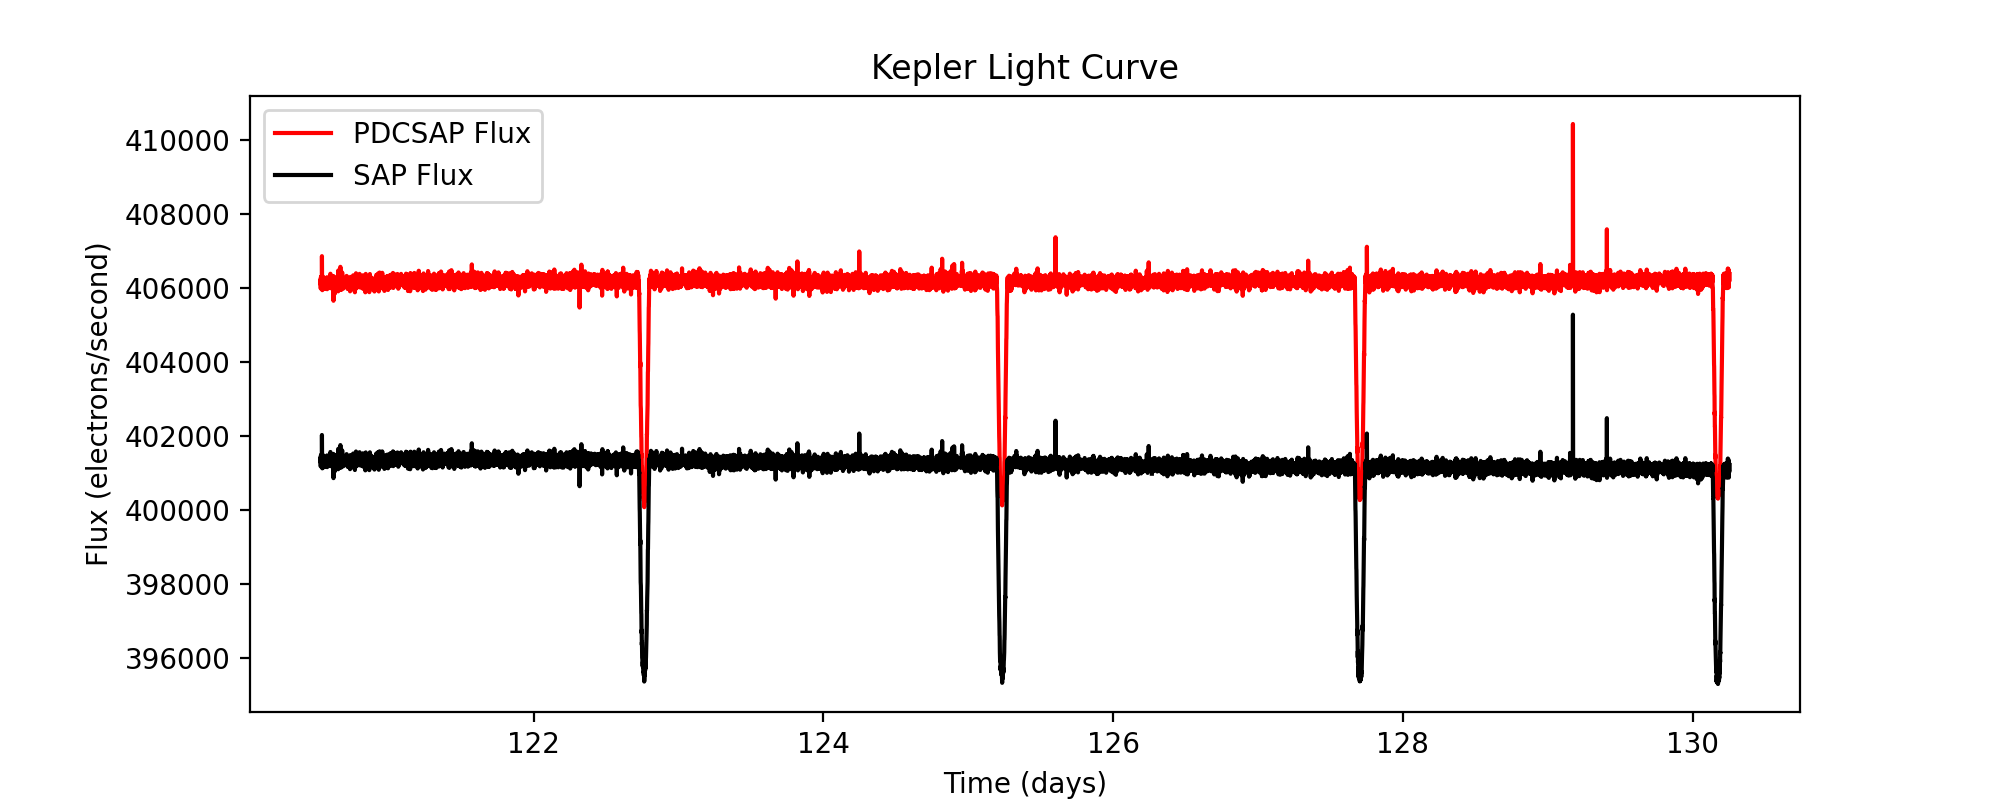

In [4]:
# Переводим BKJD в BJD
bjds = times + bjdrefi + bjdreff 

# указываем какого размера хотим график
plt.figure(figsize=(10,4))

# Отрисовываем график: блеск в зависимости от времени, '-k' и '-r' - стиль и цвет кривых, label - ярлык для кривых
#plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
#plt.plot(bjds, pdcsap_fluxes, '-r', label='PDCSAP Flux')
plt.plot(times,pdcsap_fluxes, '-r', label='PDCSAP Flux')
plt.plot(times,sap_fluxes, '-k', label='SAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')
plt.show()

Напомню: мы можем измерить период планеты, ее радиус относительно радиуса родительской звезды и продолжительность транзита

Давайте для наглядности возьмем и нормализуем PDCSAP_flux, под нормализацией имеется ввиду приведение значений к 1.

Чтобы это сделать мы берем начальные значения и делим на уровень континуума  

In [5]:
transit=pdcsap_fluxes/406000

Визуализируем

<IPython.core.display.Javascript object>


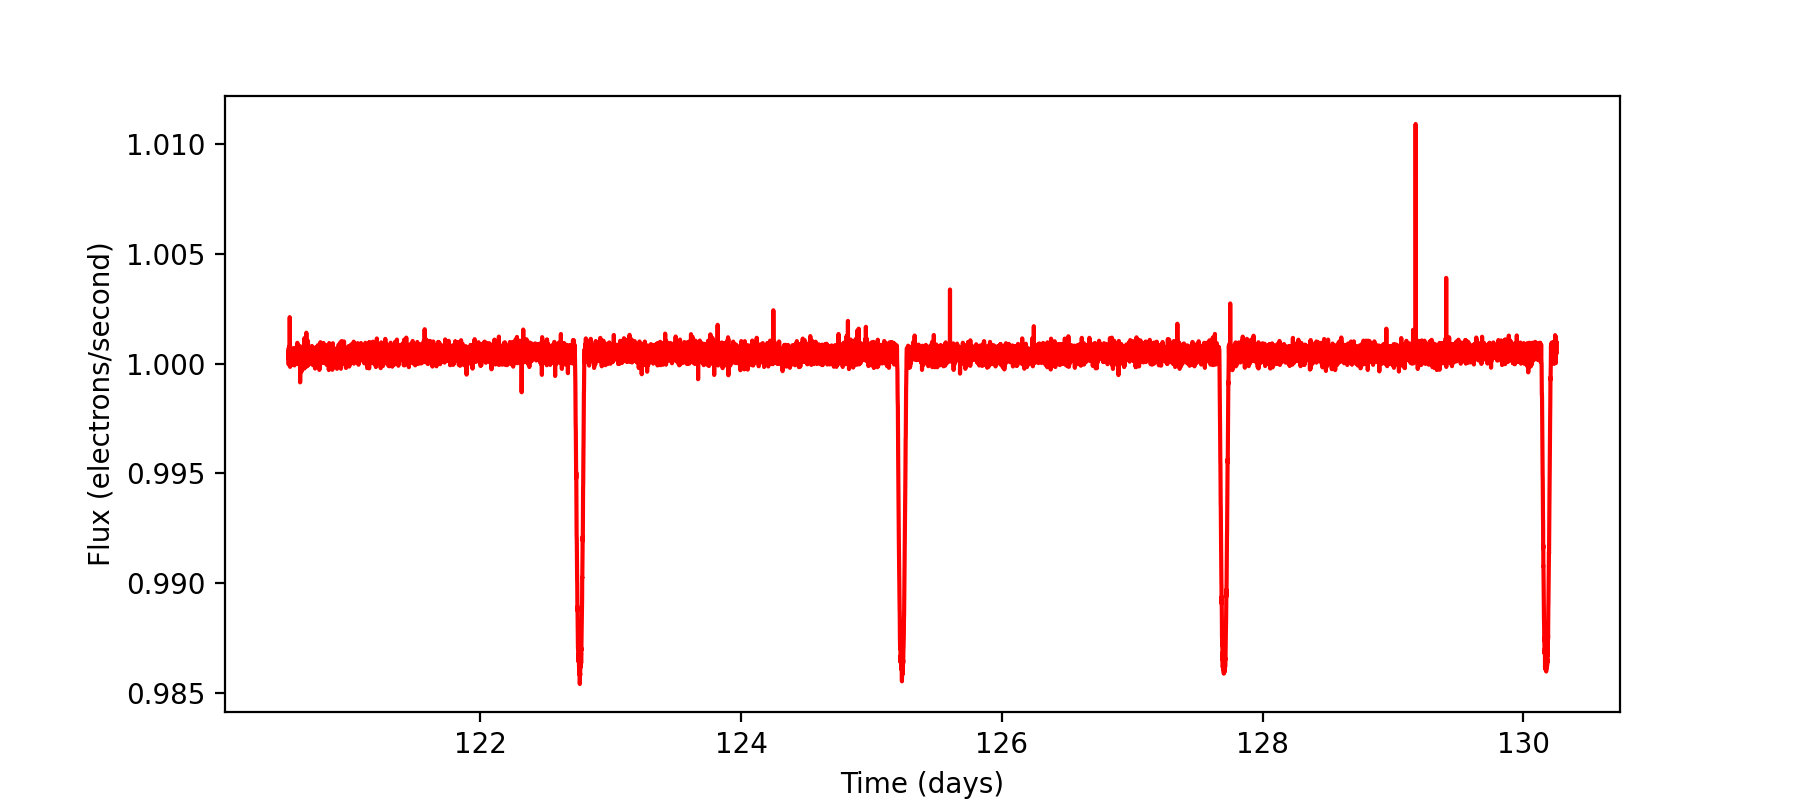

Text(0, 0.5, 'Flux (electrons/second)')

In [6]:
plt.figure(figsize=(9,4))
plt.plot(times,transit, '-r')
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')

Теперь рассмотрим эту кривую блеска, у нас 4 минимума

Благодаря магической строчке в самом начале ноутбука %matplotlib notebook наш график интерактивный и мы можем приближать, удалять и видеть в правом нижнем углу координаты точки, на которую указывает наш указатель.

Давайте узнаем какой период у планеты. Как можно догадаться, каждый раз когда планета проходит по диску родительской звезды мы видим минимум в кривой блеска. Период возникновения минимумов и есть орбитальный период планеты. Мы можем воспользоваться указателем и значениями, которые принимает ось x 

Или мы можем сделать поиск всех значений оси x - times, при которых точки графика по оси y - flux принимают значения минимума или близкие к нему. 

In [7]:
for i,x in enumerate(transit):
    if (min(transit)-0.0009<=x<=min(transit)+0.0009):
        print(times[i])

122.7579386382422
122.7586198600111
122.75930098189565
122.75998210367106
122.7606632254392
122.7613444472081
122.76202556897624
122.76338781263621
122.76406893440435
122.76475005617249
122.7654312780578
122.76611239982594
122.76679352160136
122.76747474337026
122.76815576513764
122.77019923055923
122.77088035233464
125.2284394280141
125.2291205496731
125.22980177132558
125.2304828929773
125.23116401462903
125.23252625793248
125.23320737959148
125.23388860124396
125.23456972289569
125.23525084454741
125.23593196619913
125.23661318785162
125.23797533104516
125.23865655269765
125.24001879600837
125.24070001766086
125.2420622609643
125.24274338261603
127.69485258297937
127.69553380439902
127.69757726877287
127.70098287610745
127.70166399752634
127.70234521906968
127.70302634048858
127.70370756190823
127.70506980486243
127.70575082628784
127.7071131692428
127.70915663361666
127.70983785504359
127.7105189765789
127.71256234095199
127.71324346237816
130.16671437844343
130.16807662081555
130.

Вывод показывает нам достаточно большое количество точек, но мы можем заметить, что они соответствуют 4 координатам оси х с небольшим отступом вправо и влево от них. А именно: 122.7, 125.2, 127.7, 130.1

Таким образом период можно посчитать просто вычитанием последовательных значений

Теперь перейдем к определению радиуса планеты 

Как мы помним из справки: $R_p$=$R_* \sqrt{depth}$

Из данных архива НАСА мы знаем, что $R_*$ = $0.964\pm0.038$ Солнечных радиусов

In [8]:
depth=1-min(transit)

In [9]:
depth

0.014600831280788151

подставим значения в формулу и получим радиус планеты в Солнечных радиусах.

Но мы хотим значение в радиусах Земли. 

Мы знаем, что один радиус Земли это 0.009 радиуса Солнца

Переведем значения

Теперь мы можем посчитать продолжительность транзита

Легче всего использовать курсор

А теперь можем проверить все полученные значения в архиве НАСА, 
Надо только найти цель с номером 11446443
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative